# Kurtosis Experiments

One way to gauge the error in RQMC is through replications. However it's been noted that in some cases/randomizations, the sample means from RQMC have high kurtosis as the $n$ QMC points per replication increases which makes constructing Confidence Intervals difficult/challenging. This notebook tests different randomizations for Sobol to see where the kurtosis becomes high for the largest $n$ tested. For our kurtosis experiments, we test different integrands and use RQMC with $R = 1000$ independent replications and vary $n$ from $2^0$ to $2^{8}$. We will use the following RQMC Methods for Sobol: LMS_DS, DS, and NUS. After identifying the cases where kurtois goes quite high for the largest $n$, we also winsorize the sample means (5% from each side) and see how that make a difference on the kurtosis.

Kurtosis formula: 
$
\text{Kurt}(X) = \frac{\mathbb{E}\big[(X - \mu)^4\big]}{\sigma^4}
$

We use the following integrand with any dimension $d$:

$
Y = f(\mathbf{x}) =  -d + \sum_{j=1}^d x_j e^{x_j}
$ (referred to as "smooth_anyd" in our code)


We also use the following ridge functions:

1. $ g_{jmp}(w) = 1{\{w \geq 1\}} $
2. $ g_{knk}(w) = \frac {\min(\max(−2, w), 1) + 2} {3} $
3. $ g_{smo}(w) = \Phi (w)$
4. $ g_{fin}(w) = \min(1,\sqrt{\max(w + 2, 0)}/2) $

$w = \frac{1}{\sqrt{d}} \sum_{j=1}^{d}\Phi^{-1}(x_{j})$, $\Phi(.)$ is the CDF of standard Normal Distribution on R, denoted by $ \mathcal{N}(0,1)$, and $x \sim U(0, 1)^d$.

### Here is the summary of the results obtained:

Cases with kurtosis going quite high for largest $n$ are: 
* knk (d = 1) LMS_DS - Sobol
* smo (d = 1) LMS_DS - Sobol
* fin (d = 1) LMS_DS - Sobol
* smooth_anyd (d = 1,2,4,8) LMS_DS - Sobol

Winsorizing the sample means (5% on each side) in the above cases greatly reduces the kurtosis values.

Some trends could be:
* The only randomization for Sobol for which kurtosis seems to quite high for the largest $n$ is LMS_DS
* If the function is jumpy, it doesn't seem the kurtosis goes quite high for the largest $n$ for LMS_DS for any dimension $d$
* Predominantly, the kurtosis going quite high for the largest $n$ for LMS_DS with $d = 1$, except smooth_anyd which exhibits it in all dimensions tested but the value of kurtosis seems to be going down with dimension increase. So maybe high dimensions/increase in dimension doesn't exhibit high kurtosis with largest $n$ for LMS_DS.

In [66]:
import qmcpy as qp
from scipy.stats import kurtosis,norm,mstats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Setting up the parameters to be used:

In [67]:
qmc_generators = {
    "Sobol": ["LMS_DS","DS", "NUS"]
} # The different QMC generators with different randomizations
num_randomizations = sum(len(rands) for rands in qmc_generators.values())
labels = []
for gen, rands in qmc_generators.items():
    for rand in rands:
        labels.append(f"{gen}_{rand}")
labels = np.array(labels)

R = 1000 # The number of independent replications
n_vary = 2**np.arange(0,9) # The different number of QMC points per replication

gs = {
    "jmp": lambda w: w>=1, 
    "knk": lambda w: ((np.minimum(np.maximum(-2,w),1)) + 2) / 3,
    "smo": lambda w: norm.cdf(w + 1),
    "fin": lambda w: np.minimum(1,((np.sqrt(np.maximum(w+2,0)))/2)),
    "smooth_anyd": lambda dim, w: -dim + np.sum(w * np.exp(w), axis=2)
} # The ridge functions and integrand with any dimension d

mean_arr = np.array([0.1587,0.6417, 0.76025,0.6773,0]) # The theoretical means of the functions being tested


d = np.array([1,2,4,8]) # The different d's to test on for ridge functions and integrand with any dimension d


The function to generate IID replications of QMC samples

In [68]:
def gen_qmc_samples_iid(discrete_distrib, n = 2**8, function = None, ridge = False):
    x_rld = discrete_distrib.gen_samples(n).reshape((discrete_distrib.replications,n,discrete_distrib.d))
    if ridge is True:
        return x_rld
    if function is None:
        y_rld = x_rld[...,0]
    else:
        y_rld = function(x_rld)
    return y_rld.mean(1),y_rld.flatten()

Generating the QMC samples that will be used in both the ridge and integrands

In [69]:
x_qmc_arr = np.empty((len(labels), len(n_vary)), dtype=object)
counter = 0
for gen, rands in qmc_generators.items():
    for rand in rands:
        for i in range(len(n_vary)):
            if gen.lower() == "sobol":
                distrib = qp.Sobol(d[-1], randomize = rand, replications = R)
            elif gen.lower() == 'halton':
                distrib = qp.Halton(d[-1], randomize = rand, replications = R)
            else:
                distrib = qp.Lattice(d[-1], randomize = rand, replications = R)
            x_qmc_arr[counter,i] = gen_qmc_samples_iid(discrete_distrib=distrib,n = n_vary[i],ridge = True)
        counter = counter + 1

### Ridge Function and Integrand with any dimension $d$ Simulation

In [70]:
qmc_arr_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)),dtype=object)
kurr_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
var_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
error_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
counter = 0
for gen, rands in qmc_generators.items():
    for rand in rands:
        for i in range(len(n_vary)):
            x_qmc = norm.ppf(x_qmc_arr[counter, i])
            for j in range (len(d)):
                w_qmc = x_qmc[:, :, :d[j]].sum(axis = 2)/np.sqrt(d[j])
                g_counter = 0
                for g in gs.values():
                    if g_counter == (len(gs) - 1):
                        x_qmc_int = x_qmc_arr[counter, i]
                        w_qmc = x_qmc_int[:,:,:d[j]]
                        qmc_arr_ridge[counter, j, g_counter,i] = g(d[j],w_qmc).mean(axis = 1)
                    else:
                        qmc_arr_ridge[counter, j, g_counter,i] = g(w_qmc).mean(axis = 1)
                    kurr_ridge[counter, j, g_counter, i] = kurtosis(qmc_arr_ridge[counter, j, g_counter,i], bias=False, fisher=False)
                    var_ridge[counter, j, g_counter, i] = np.var(qmc_arr_ridge[counter, j, g_counter,i], ddof=1)
                    error_ridge[counter, j, g_counter, i] = np.abs(np.mean(qmc_arr_ridge[counter, j, g_counter,i]) - mean_arr[g_counter])
                    g_counter = g_counter + 1
        counter = counter + 1

Summary of results restated:

Cases with kurtosis going quite high for largest $n$ are: 
* knk (d = 1) LMS_DS - Sobol
* smo (d = 1) LMS_DS - Sobol
* fin (d = 1) LMS_DS - Sobol
* smooth_anyd (d = 1,2,4,8) LMS_DS - Sobol

Some trends could be:
* The only randomization for Sobol for which kurtosis seems to quite high for the largest $n$ is LMS_DS
* If the function is jumpy, it doesn't seem the kurtosis goes quite high for the largest $n$ for LMS_DS for any dimension $d$
* Predominantly, the kurtosis going quite high for the largest $n$ for LMS_DS with $d = 1$, except smooth_anyd which exhibits it in all dimensions tested but the value of kurtosis seems to be going down with dimension increase. So maybe high dimensions/increase in dimension doesn't exhibit high kurtosis with largest $n$ for LMS_DS.

Kurtosis, Variance, and Error of R replications vs $n$ for Ridge Function and Integrand with any dimension $d$ Simulations

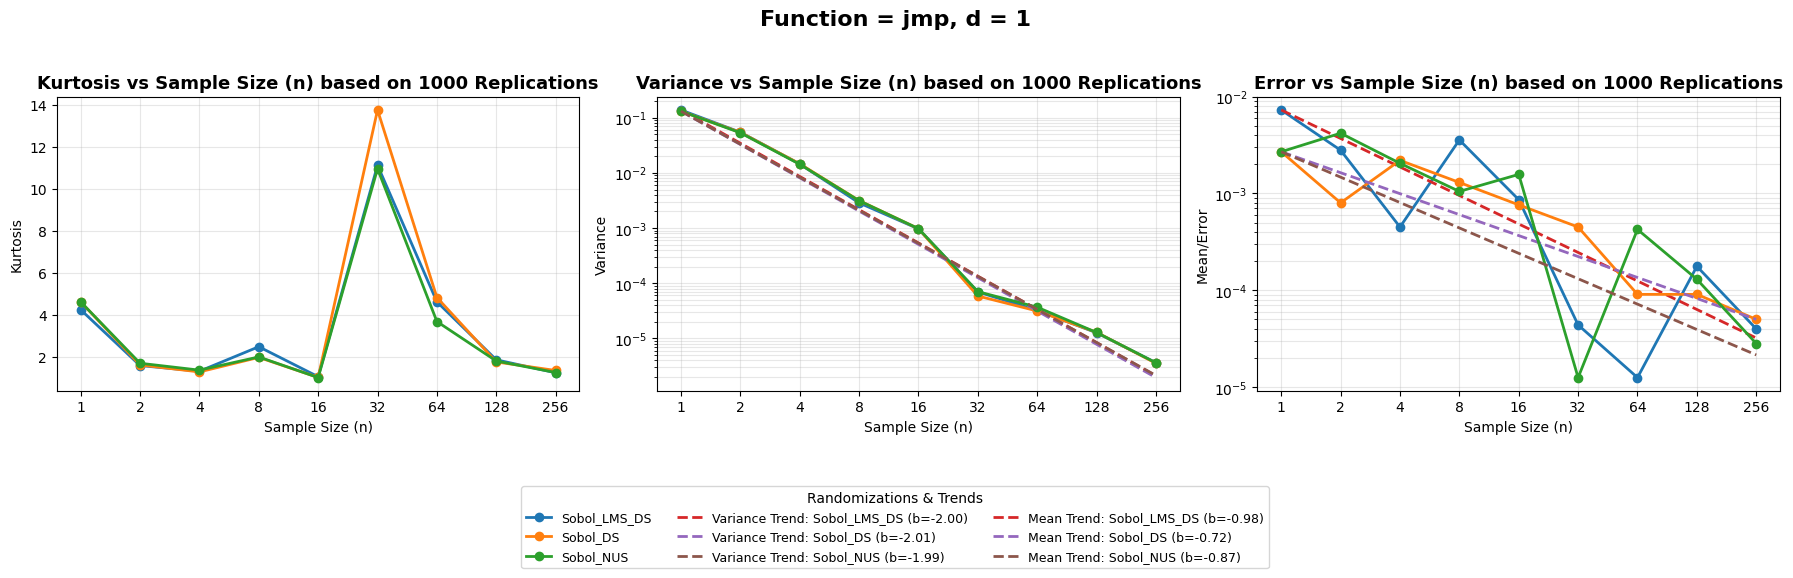

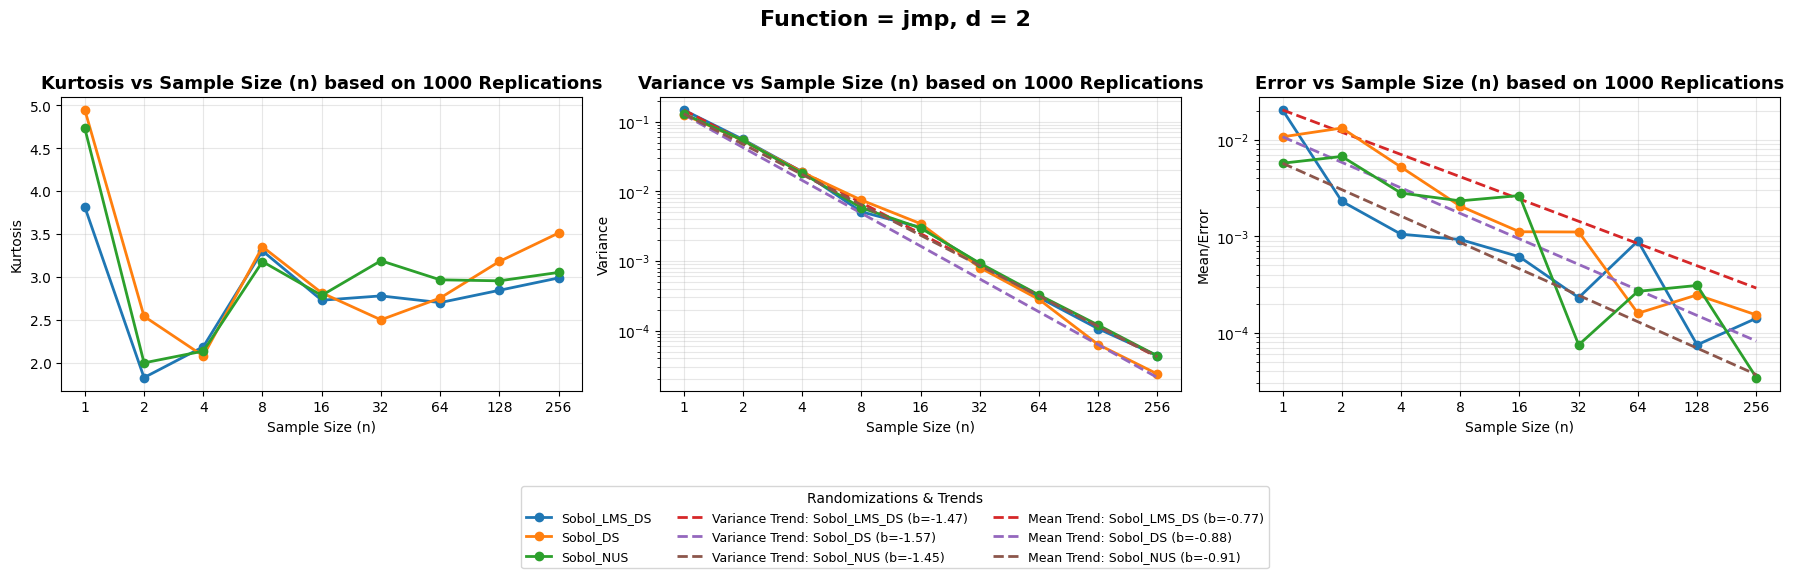

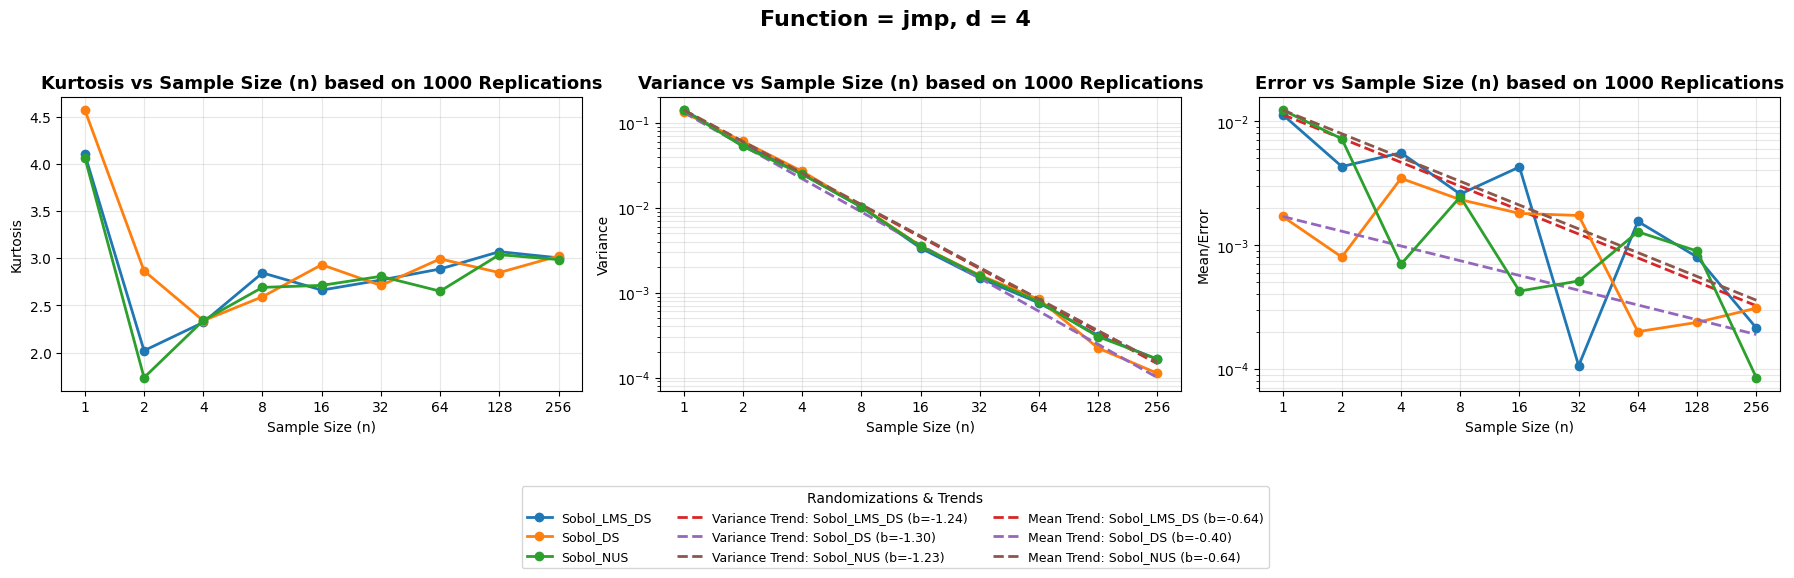

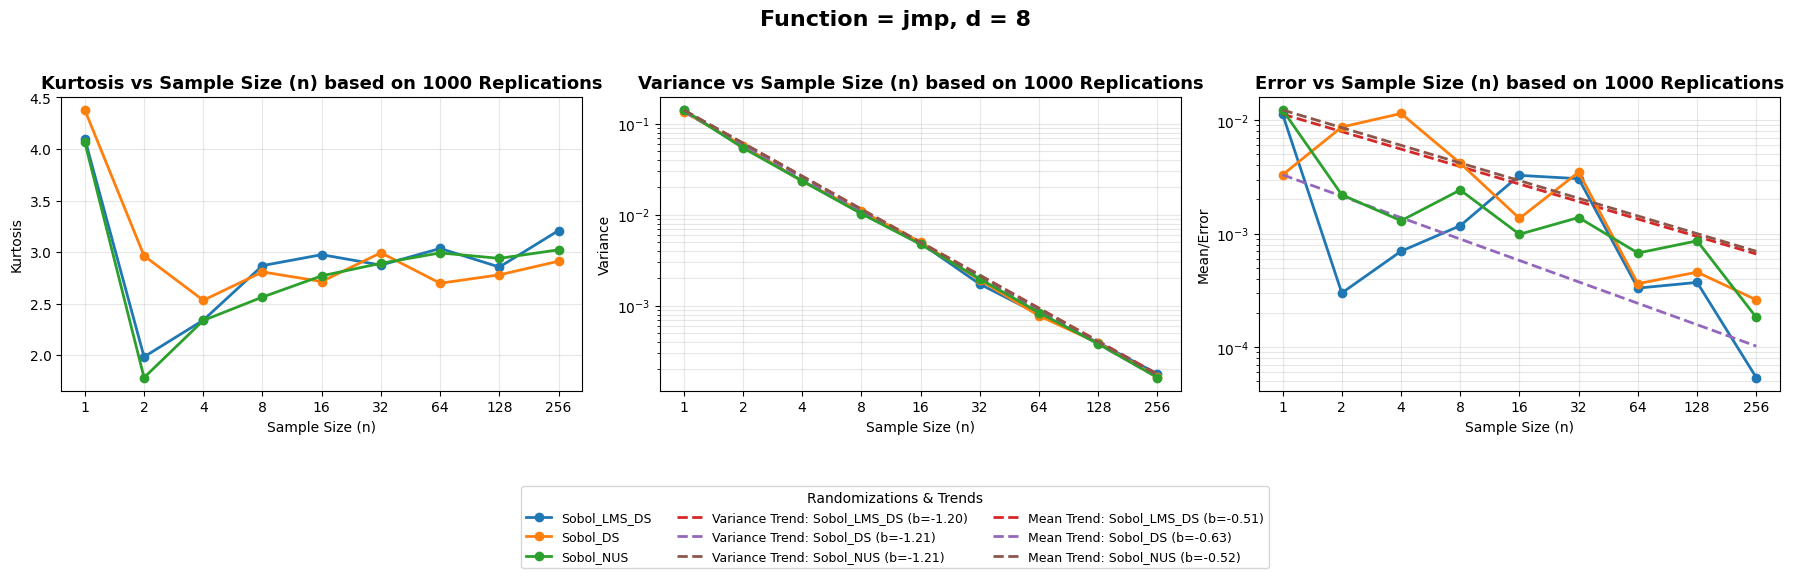

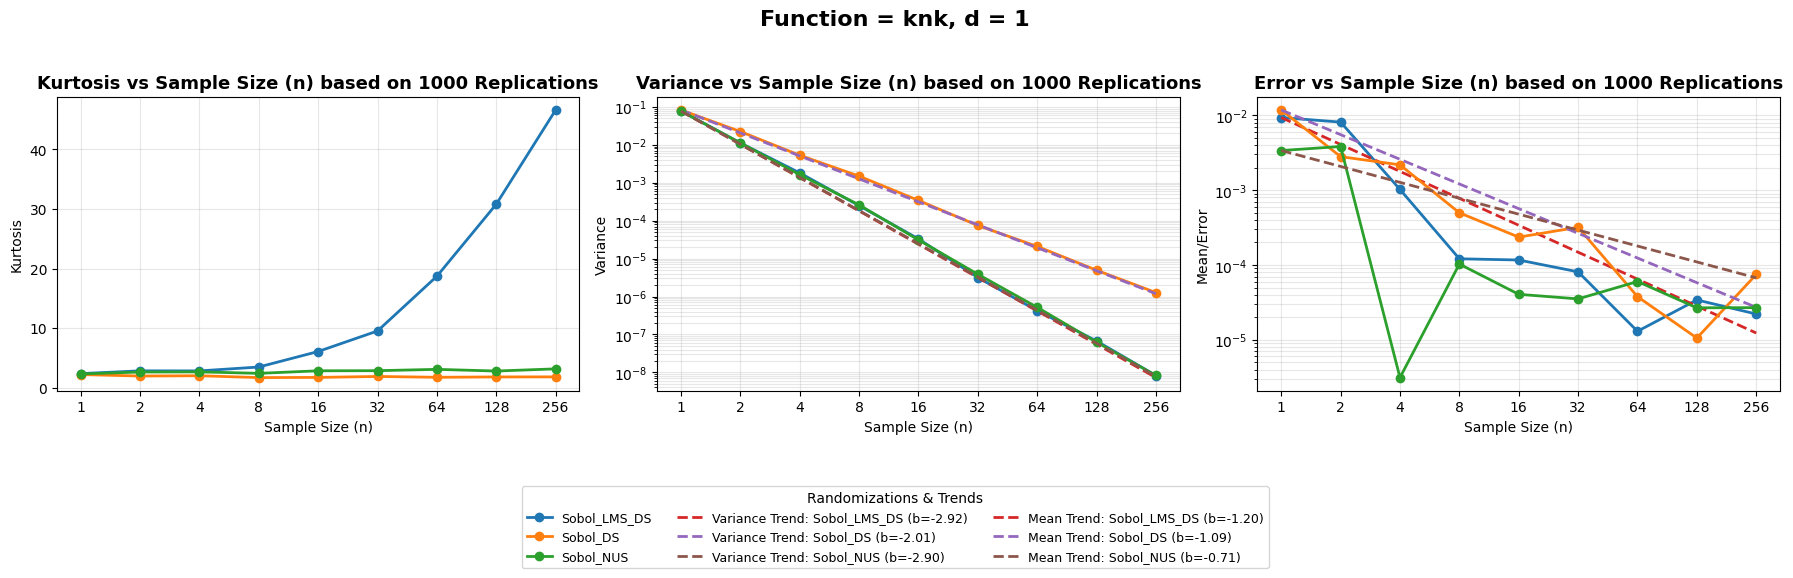

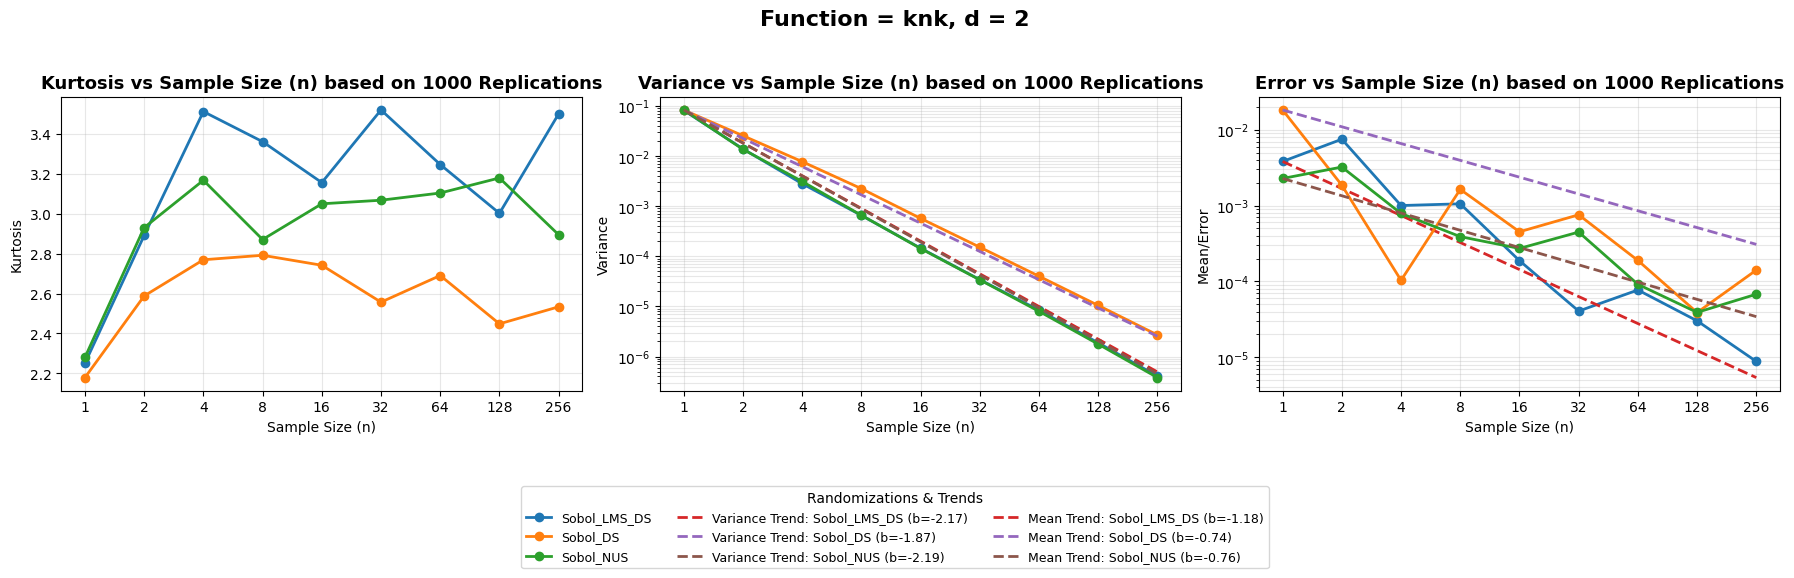

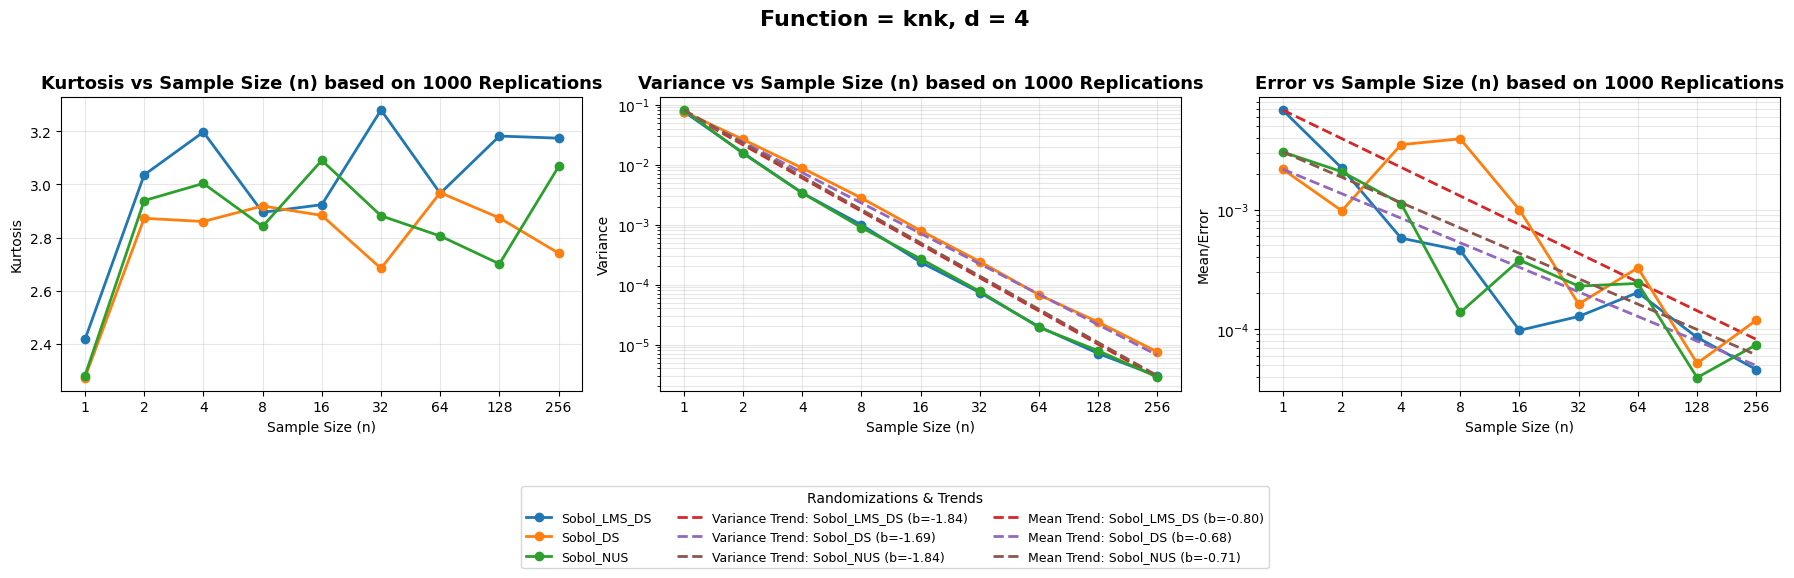

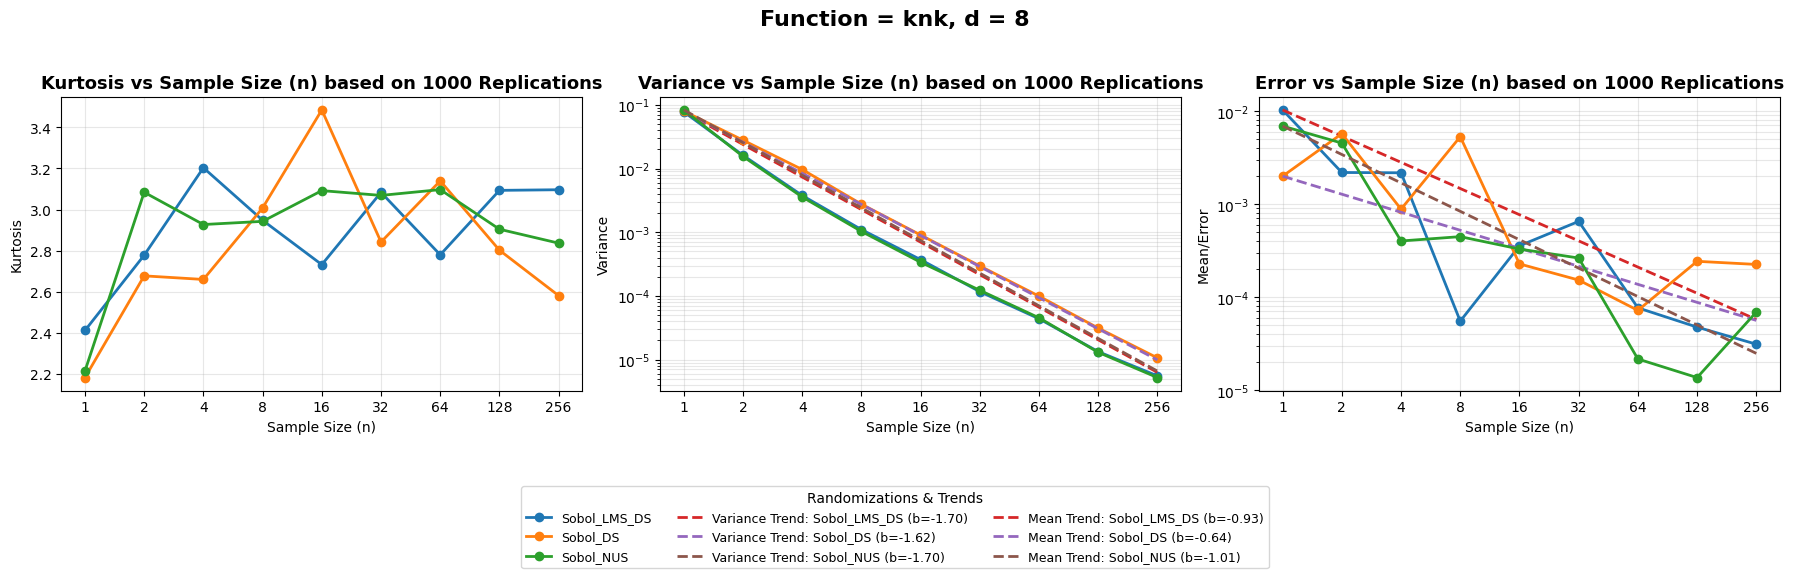

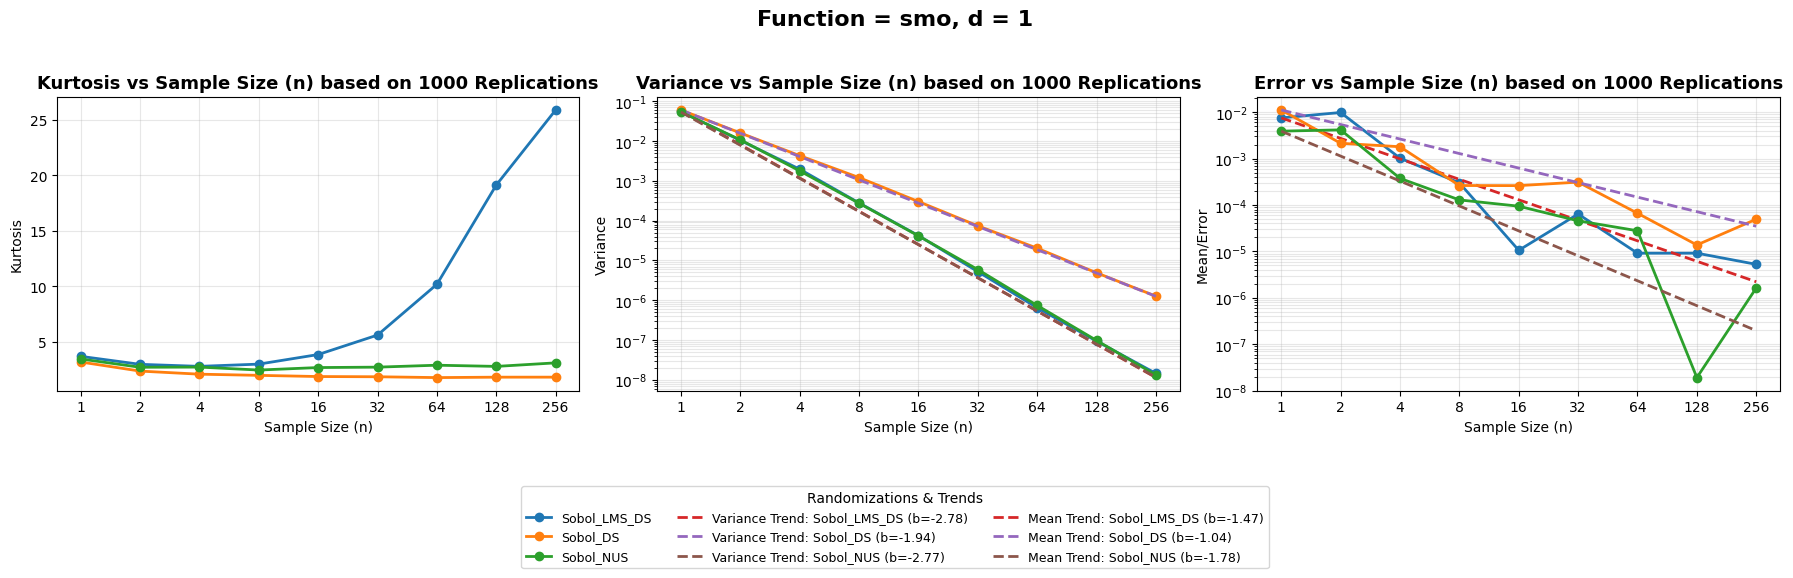

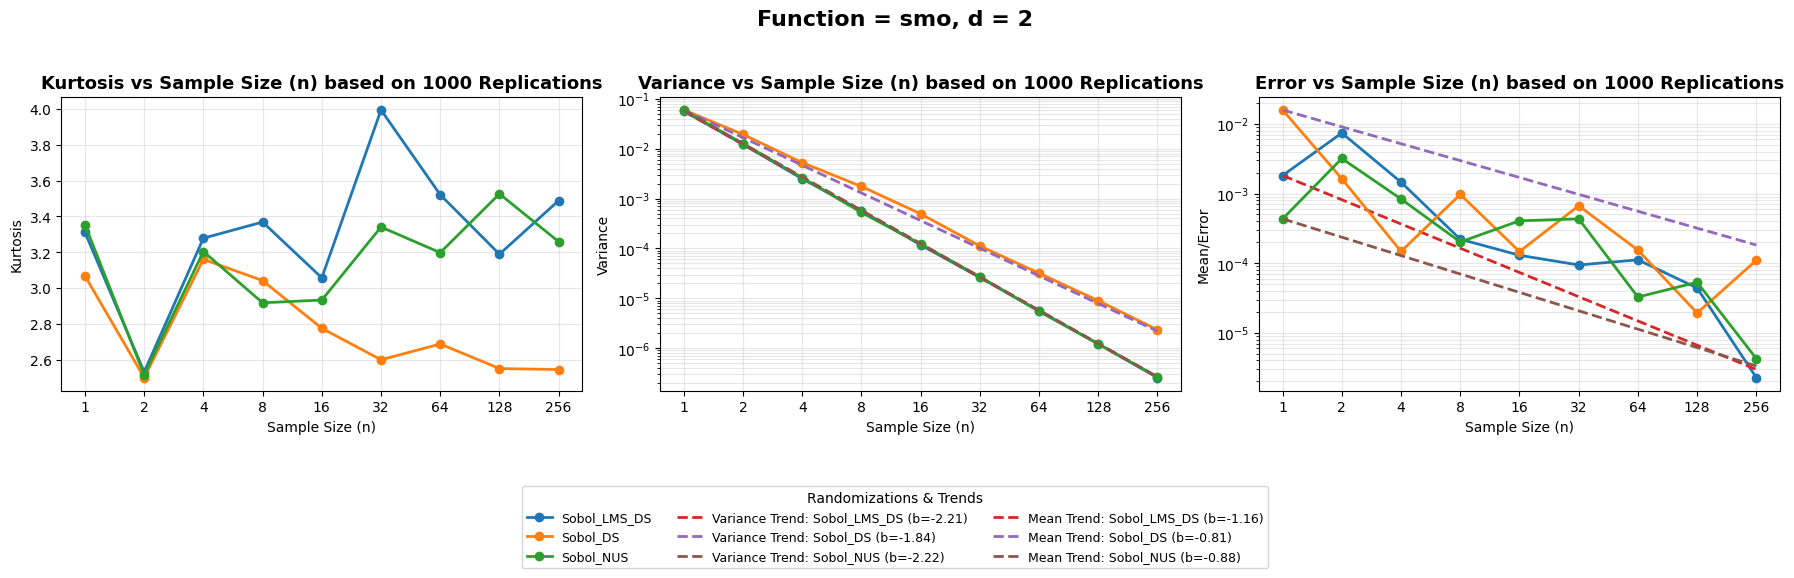

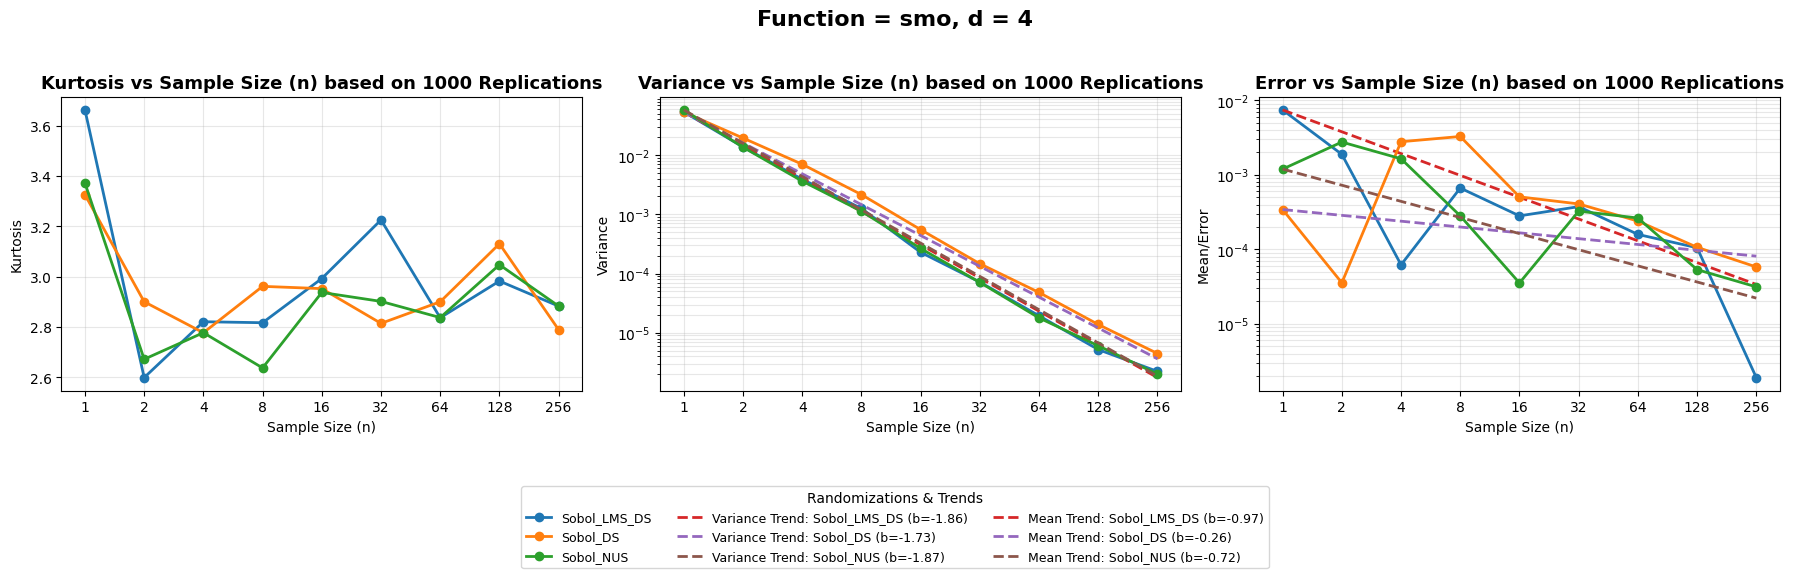

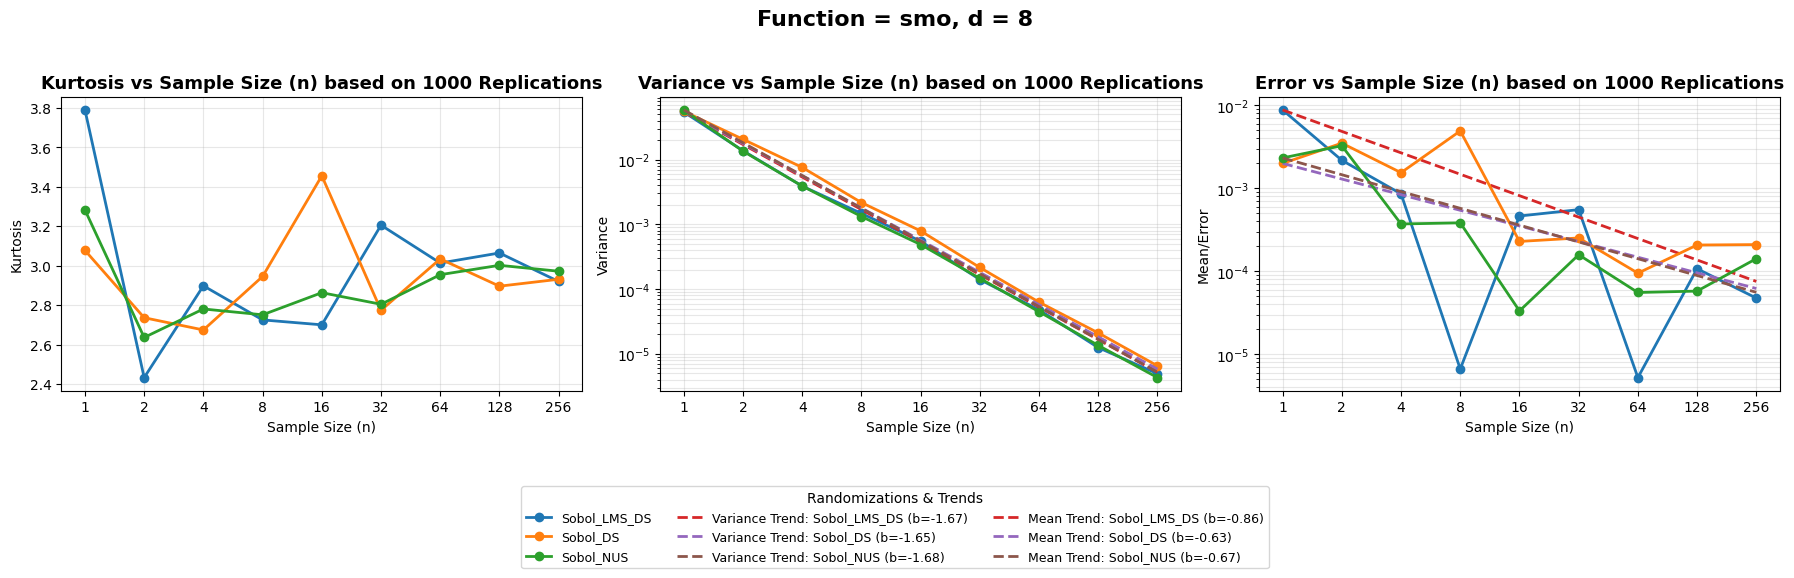

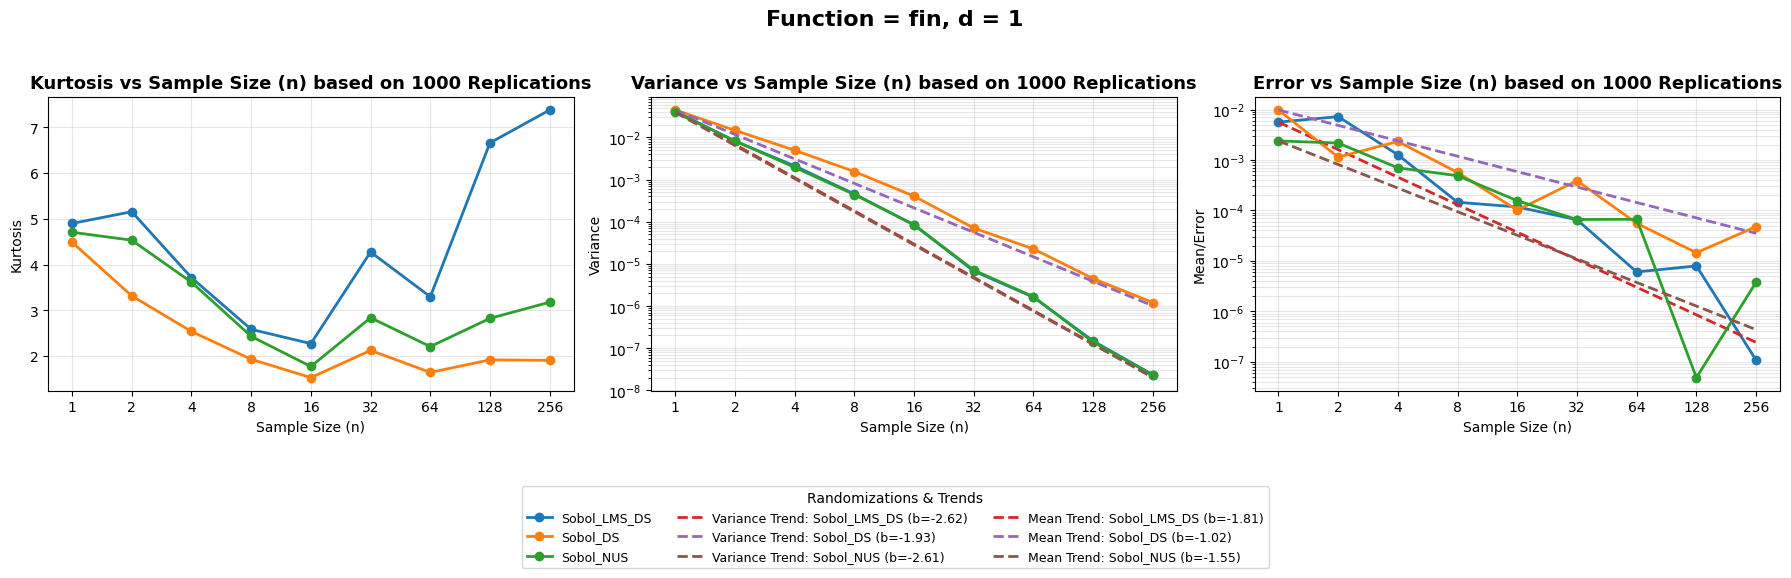

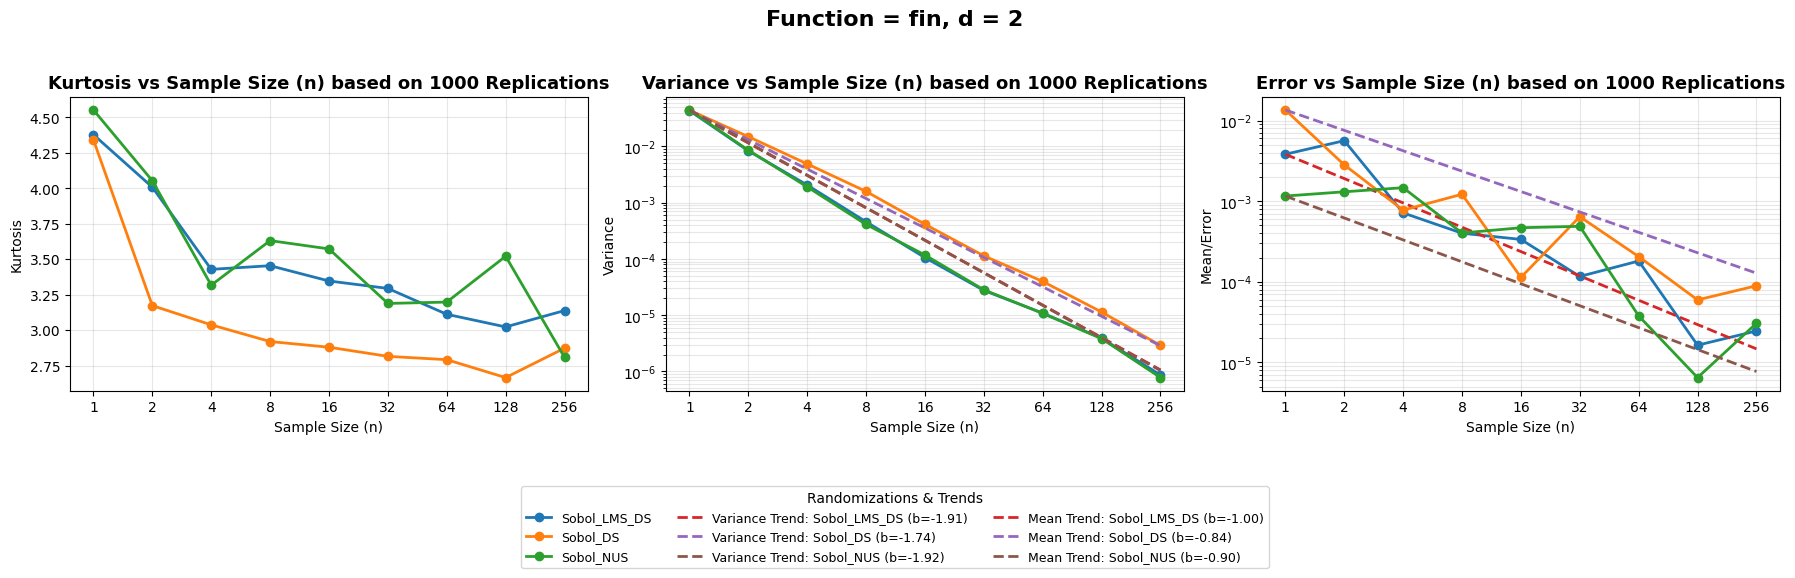

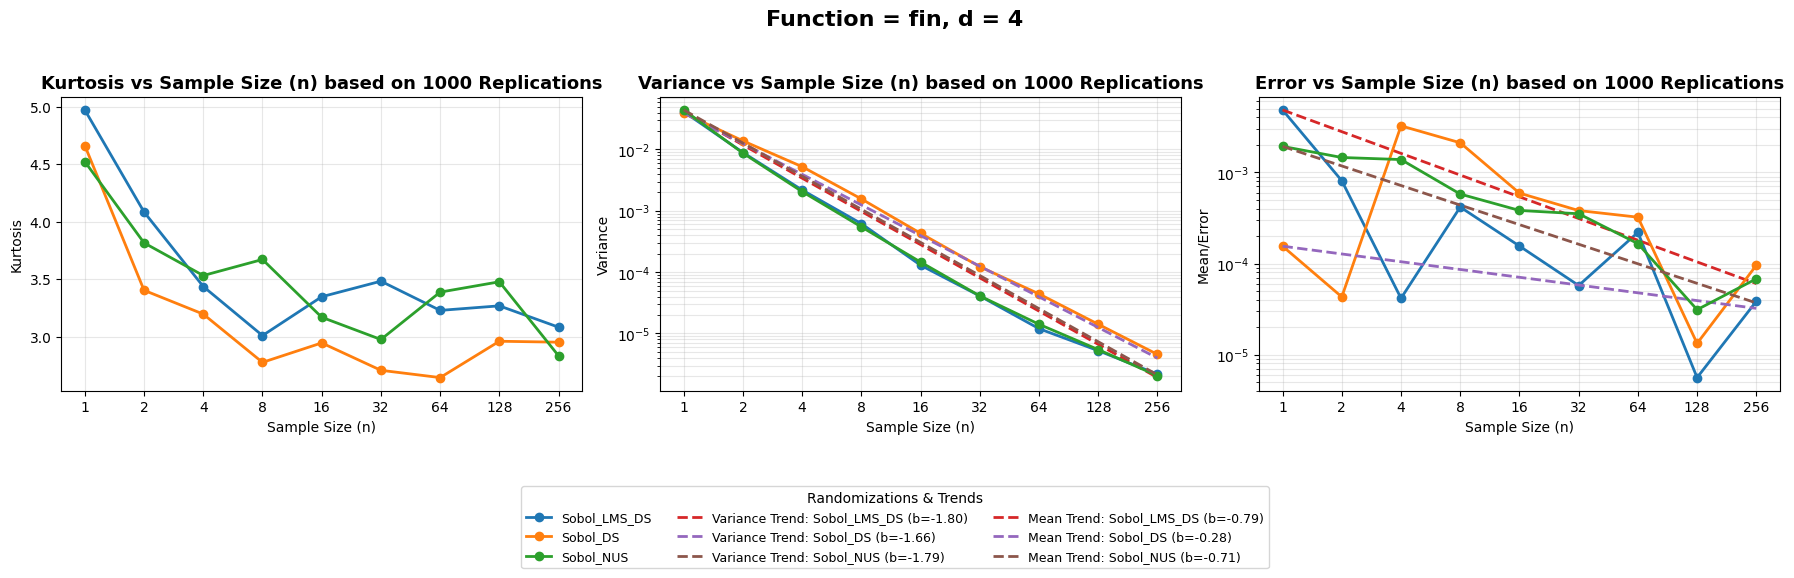

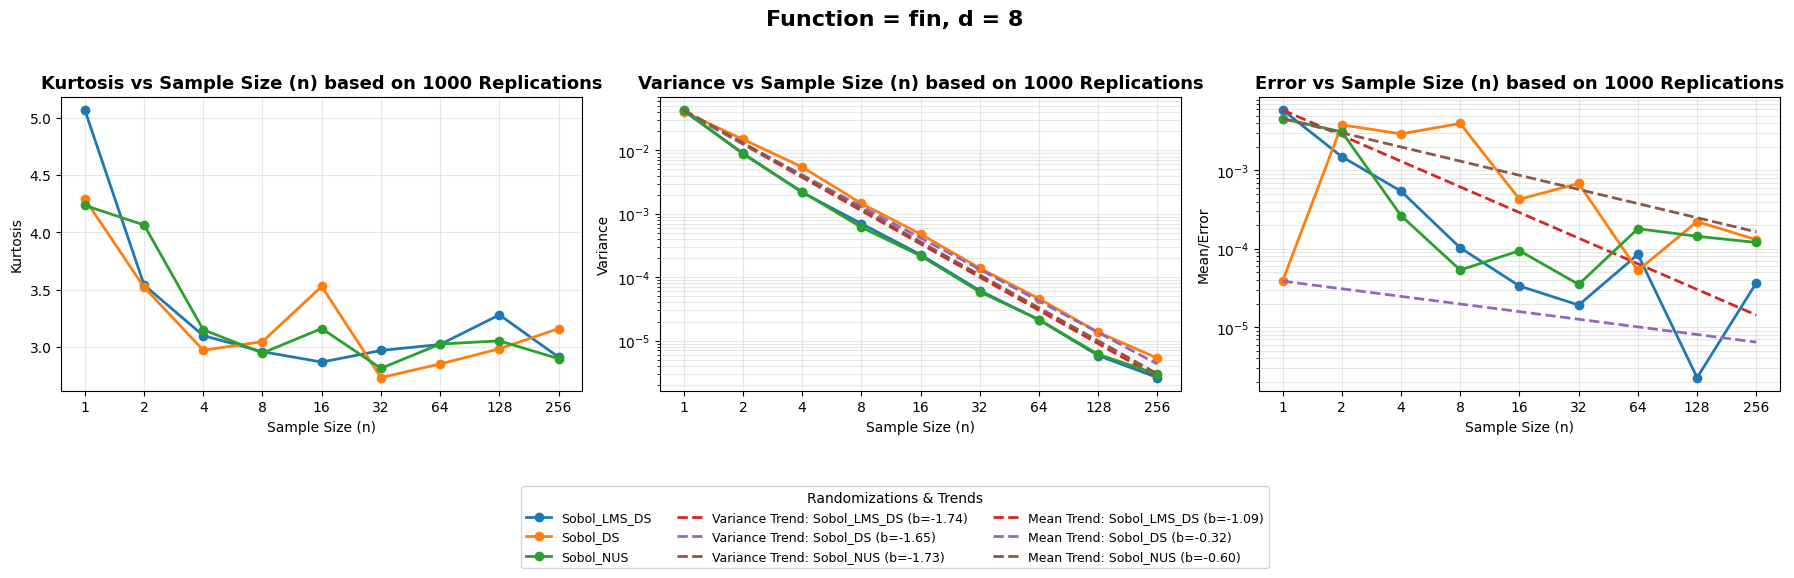

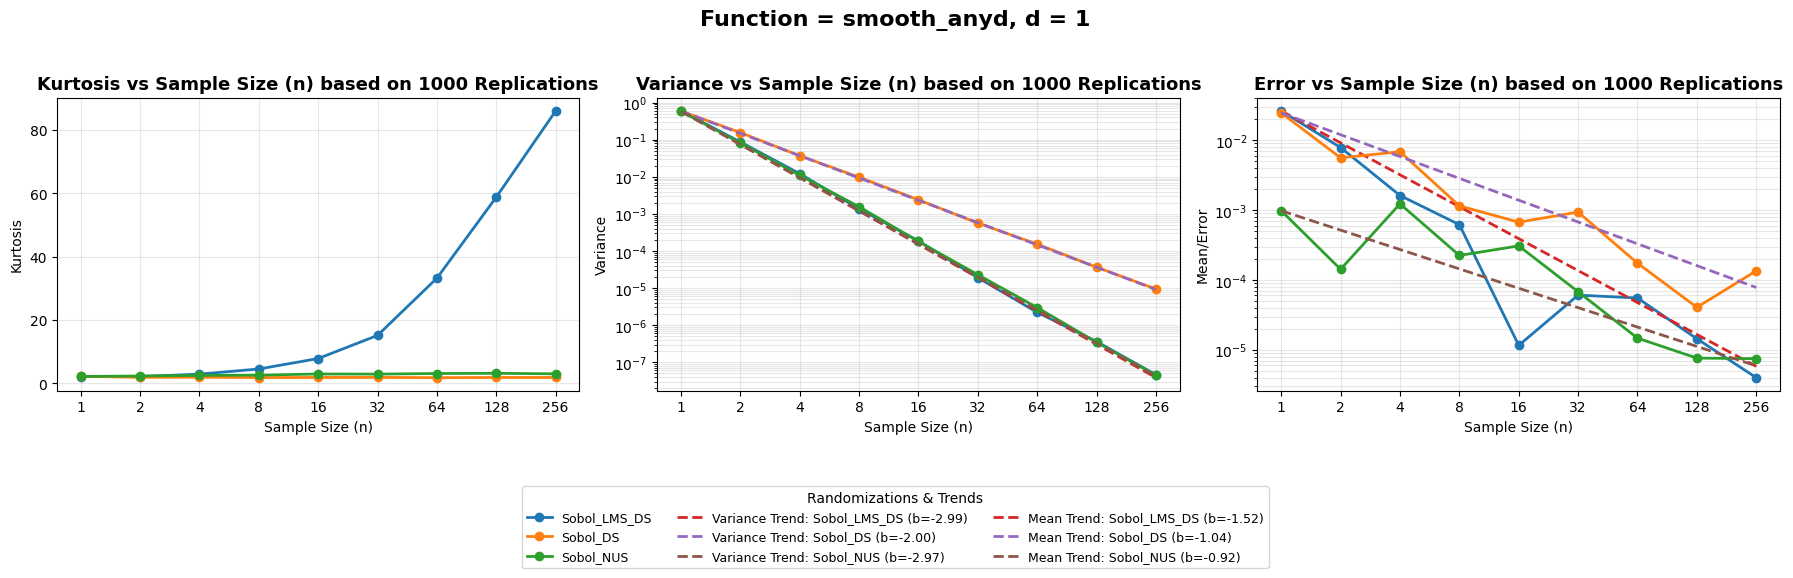

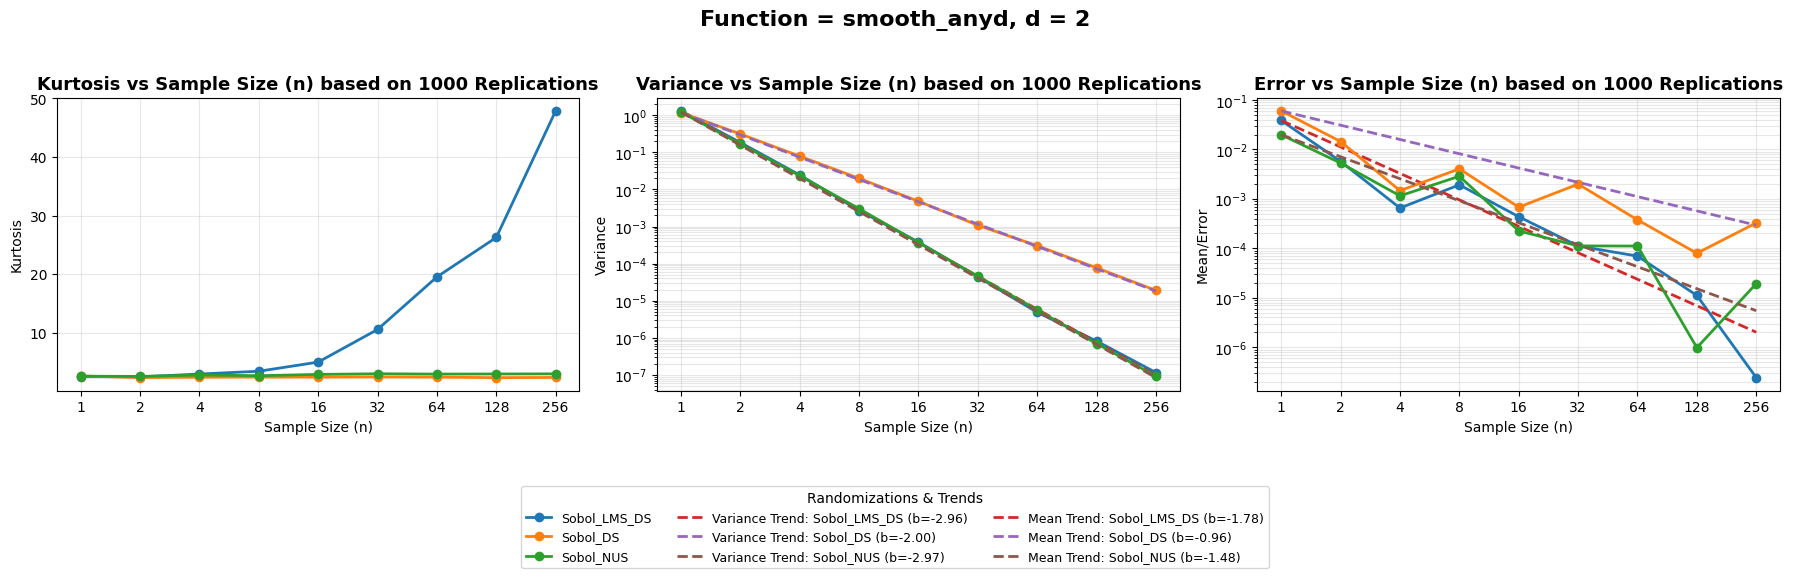

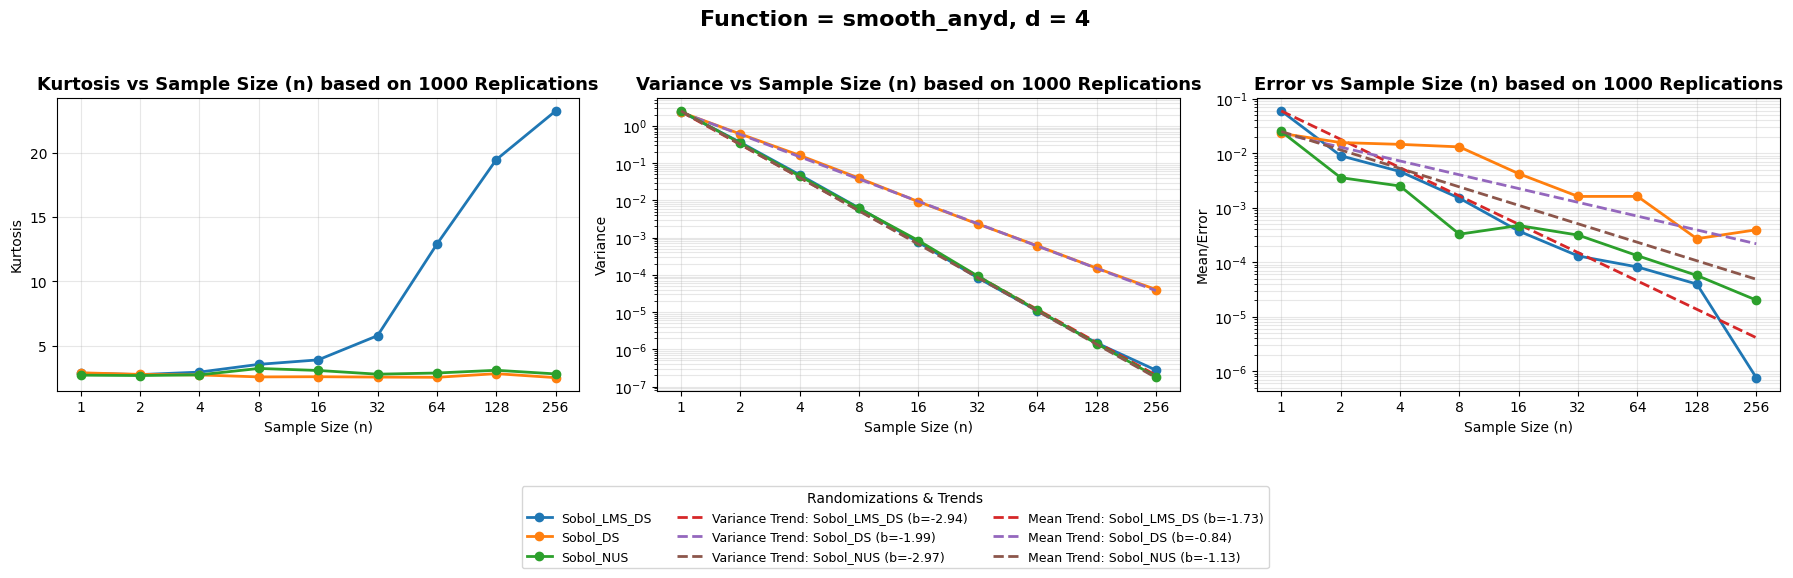

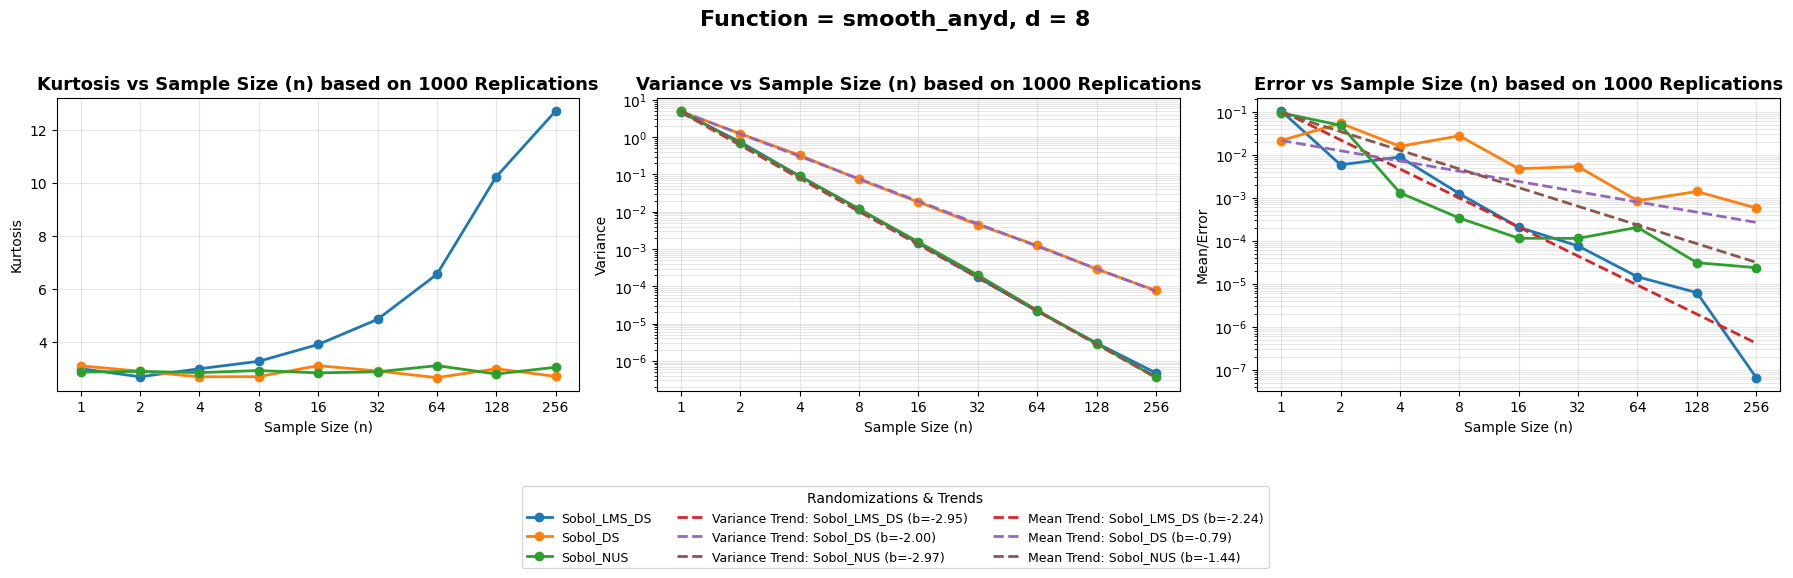

In [71]:
for i_g, (gname, gfunc) in enumerate(gs.items()):
    for i_d, dd in enumerate(d):

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        ax_kurt, ax_var, ax_mean = axes

        # Get the default color cycle
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors_cycle = prop_cycle.by_key()['color']
        
        # Store colors from first plot
        colors = []
        for i_l, label in enumerate(labels):
            line = ax_kurt.plot(
                n_vary,
                kurr_ridge[i_l, i_d, i_g, :],
                marker='o', linewidth=2, markersize=6,
                label=label
            )[0]
            colors.append(line.get_color())  # Save the color
            
        ax_kurt.set_xscale('log', base=2)
        ax_kurt.set_xticks(n_vary)
        ax_kurt.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_kurt.set_xlabel("Sample Size (n)")
        ax_kurt.set_ylabel("Kurtosis")
        ax_kurt.set_title(f"Kurtosis vs Sample Size (n) based on {R} Replications", fontsize=13, weight='bold')
        ax_kurt.grid(True, which="both", alpha=0.3)
        ax_kurt.tick_params(axis="both", labelsize=10)

        # Use different colors for trend lines (offset from the data colors)
        num_labels = len(labels)
        trend_colors = [colors_cycle[(i_l + num_labels) % len(colors_cycle)] for i_l in range(num_labels)]
        
        var_trends = []
        for i_l, label in enumerate(labels):
            y = var_ridge[i_l, i_d, i_g, :]
            ax_var.plot(n_vary, y, marker='o', linewidth=2, markersize=6, 
                       label=label, color=colors[i_l])  # Use saved color for data line
            coeffs = np.polyfit(np.log(n_vary), np.log(y), 1)
            b = coeffs[0]
            trend = y[0] * (n_vary / n_vary[0])**b
            # Use offset color for trend line
            trend_line, = ax_var.plot(n_vary, trend, linestyle='--', linewidth=2,
                                       label=f"Variance Trend: {label} (b={b:.2f})",
                                       color=trend_colors[i_l])

        ax_var.set_xscale('log', base=2)
        ax_var.set_yscale('log')
        ax_var.set_xticks(n_vary)
        ax_var.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_var.set_xlabel("Sample Size (n)")
        ax_var.set_ylabel("Variance")
        ax_var.set_title(f"Variance vs Sample Size (n) based on {R} Replications", fontsize=13, weight='bold')
        ax_var.grid(True, which="both", alpha=0.3)
        ax_var.tick_params(axis="both", labelsize=10)

        mean_trends = []
        for i_l, label in enumerate(labels):
            y = np.abs(error_ridge[i_l, i_d, i_g, :])
            ax_mean.plot(n_vary, y, marker='o', linewidth=2, markersize=6, 
                        label=label, color=colors[i_l])  # Use saved color for data line
            coeffs = np.polyfit(np.log(n_vary), np.log(y), 1)
            b = coeffs[0]
            trend = y[0] * (n_vary / n_vary[0])**b
            # Use the same trend color from variance plot
            trend_line, = ax_mean.plot(n_vary, trend, linestyle='--', linewidth=2,
                                        label=f"Mean Trend: {label} (b={b:.2f})",
                                        color=trend_colors[i_l])

        ax_mean.set_xscale('log', base=2)
        ax_mean.set_yscale('log')
        ax_mean.set_xticks(n_vary)
        ax_mean.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_mean.set_xlabel("Sample Size (n)")
        ax_mean.set_ylabel("Mean/Error")
        ax_mean.set_title(f"Error vs Sample Size (n) based on {R} Replications", fontsize=13, weight='bold')
        ax_mean.grid(True, which="both", alpha=0.3)
        ax_mean.tick_params(axis="both", labelsize=10)

        fig.suptitle(f"Function = {gname}, d = {dd}", fontsize=16, weight='bold')

        # Collect all legend handles from all three axes
        handles_labels = []
        for ax in [ax_kurt, ax_var, ax_mean]:
            h, l = ax.get_legend_handles_labels()
            for handle, lbl in zip(h, l):
                handles_labels.append((handle, lbl))

        # Remove duplicates while preserving order
        seen = set()
        unique_handles_labels = []
        for handle, lbl in handles_labels:
            if lbl not in seen:
                unique_handles_labels.append((handle, lbl))
                seen.add(lbl)

        if unique_handles_labels:
            handles, labels_ = zip(*unique_handles_labels)
            fig.legend(
                handles, labels_,
                title="Randomizations & Trends",
                title_fontsize=10, fontsize=9,
                loc='lower center',
                ncol=3,
                bbox_to_anchor=(0.5, -0.15)
            )

        fig.tight_layout(rect=[0, 0.1, 1, 0.95])
        plt.show()

### Identifying cases where kurtosis goes quite high for the largest $n$ (restating the results):

Cases with kurtosis going quite high for largest $n$ are: 
* knk (d = 1) LMS_DS - Sobol
* smo (d = 1) LMS_DS - Sobol
* fin (d = 1) LMS_DS - Sobol
* smooth_anyd (d = 1,2,4,8) LMS_DS - Sobol


Some trends could be:
* The only randomization for Sobol for which kurtosis seems to quite high for the largest $n$ is LMS_DS
* If the function is jumpy, it doesn't seem the kurtosis goes quite high for the largest $n$ for LMS_DS for any dimension $d$
* Predominantly, the kurtosis going quite high for the largest $n$ for LMS_DS with $d = 1$, except smooth_anyd which exhibits it in all dimensions tested but the value of kurtosis seems to be going down with dimension increase. So maybe high dimensions/increase in dimension doesn't exhibit high kurtosis with largest $n$ for LMS_DS.

### Using Winsorize for cases where kurtosis goes quite high for largest $n$

We will use winsorize (5% on each side) for cases where kurtosis goes quite high for the largest $n$ and see how that makes a difference on the kurtois values. The plots show that winsorization greatly reduces the kurtosis values

In [72]:
# knk_d1
knk_d1 = np.empty(len(n_vary), dtype=object)
kur_knk_d1 = np.empty(len(n_vary))
for i in range(len(n_vary)):
    knk_d1[i] = mstats.winsorize(qmc_arr_ridge[0, 0, 1, i], limits=[0.05, 0.05])
    kur_knk_d1[i] = kurtosis(knk_d1[i], bias=False, fisher=False)

# smo_d1
smo_d1 = np.empty(len(n_vary), dtype=object)
kur_smo_d1 = np.empty(len(n_vary))
for i in range(len(n_vary)):
    smo_d1[i] = mstats.winsorize(qmc_arr_ridge[0, 0, 2, i], limits=[0.05, 0.05])
    kur_smo_d1[i] = kurtosis(smo_d1[i], bias=False, fisher=False)

# fin_d1
fin_d1 = np.empty(len(n_vary), dtype=object)
kur_fin_d1 = np.empty(len(n_vary))
for i in range(len(n_vary)):
    fin_d1[i] = mstats.winsorize(qmc_arr_ridge[0, 0, 3, i], limits=[0.05, 0.05])
    kur_fin_d1[i] = kurtosis(fin_d1[i], bias=False, fisher=False)

# smooth_any_d (this one has 2D: d and n_vary)
smooth_any_d = np.empty((len(d), len(n_vary)), dtype=object)
kur_smooth_any_d = np.empty((len(d), len(n_vary)))
for j in range(len(d)):
    for i in range(len(n_vary)):
        smooth_any_d[j, i] = mstats.winsorize(qmc_arr_ridge[0, j, 4, i], limits=[0.05, 0.05])
        kur_smooth_any_d[j, i] = kurtosis(smooth_any_d[j, i], bias=False, fisher=False)


Original Kurtosis vs Sample Size $n$ and Winsorized Kurtosis vs Sample Size $n$ for cases where the Original Kurtosis was going high with the largest $n$:

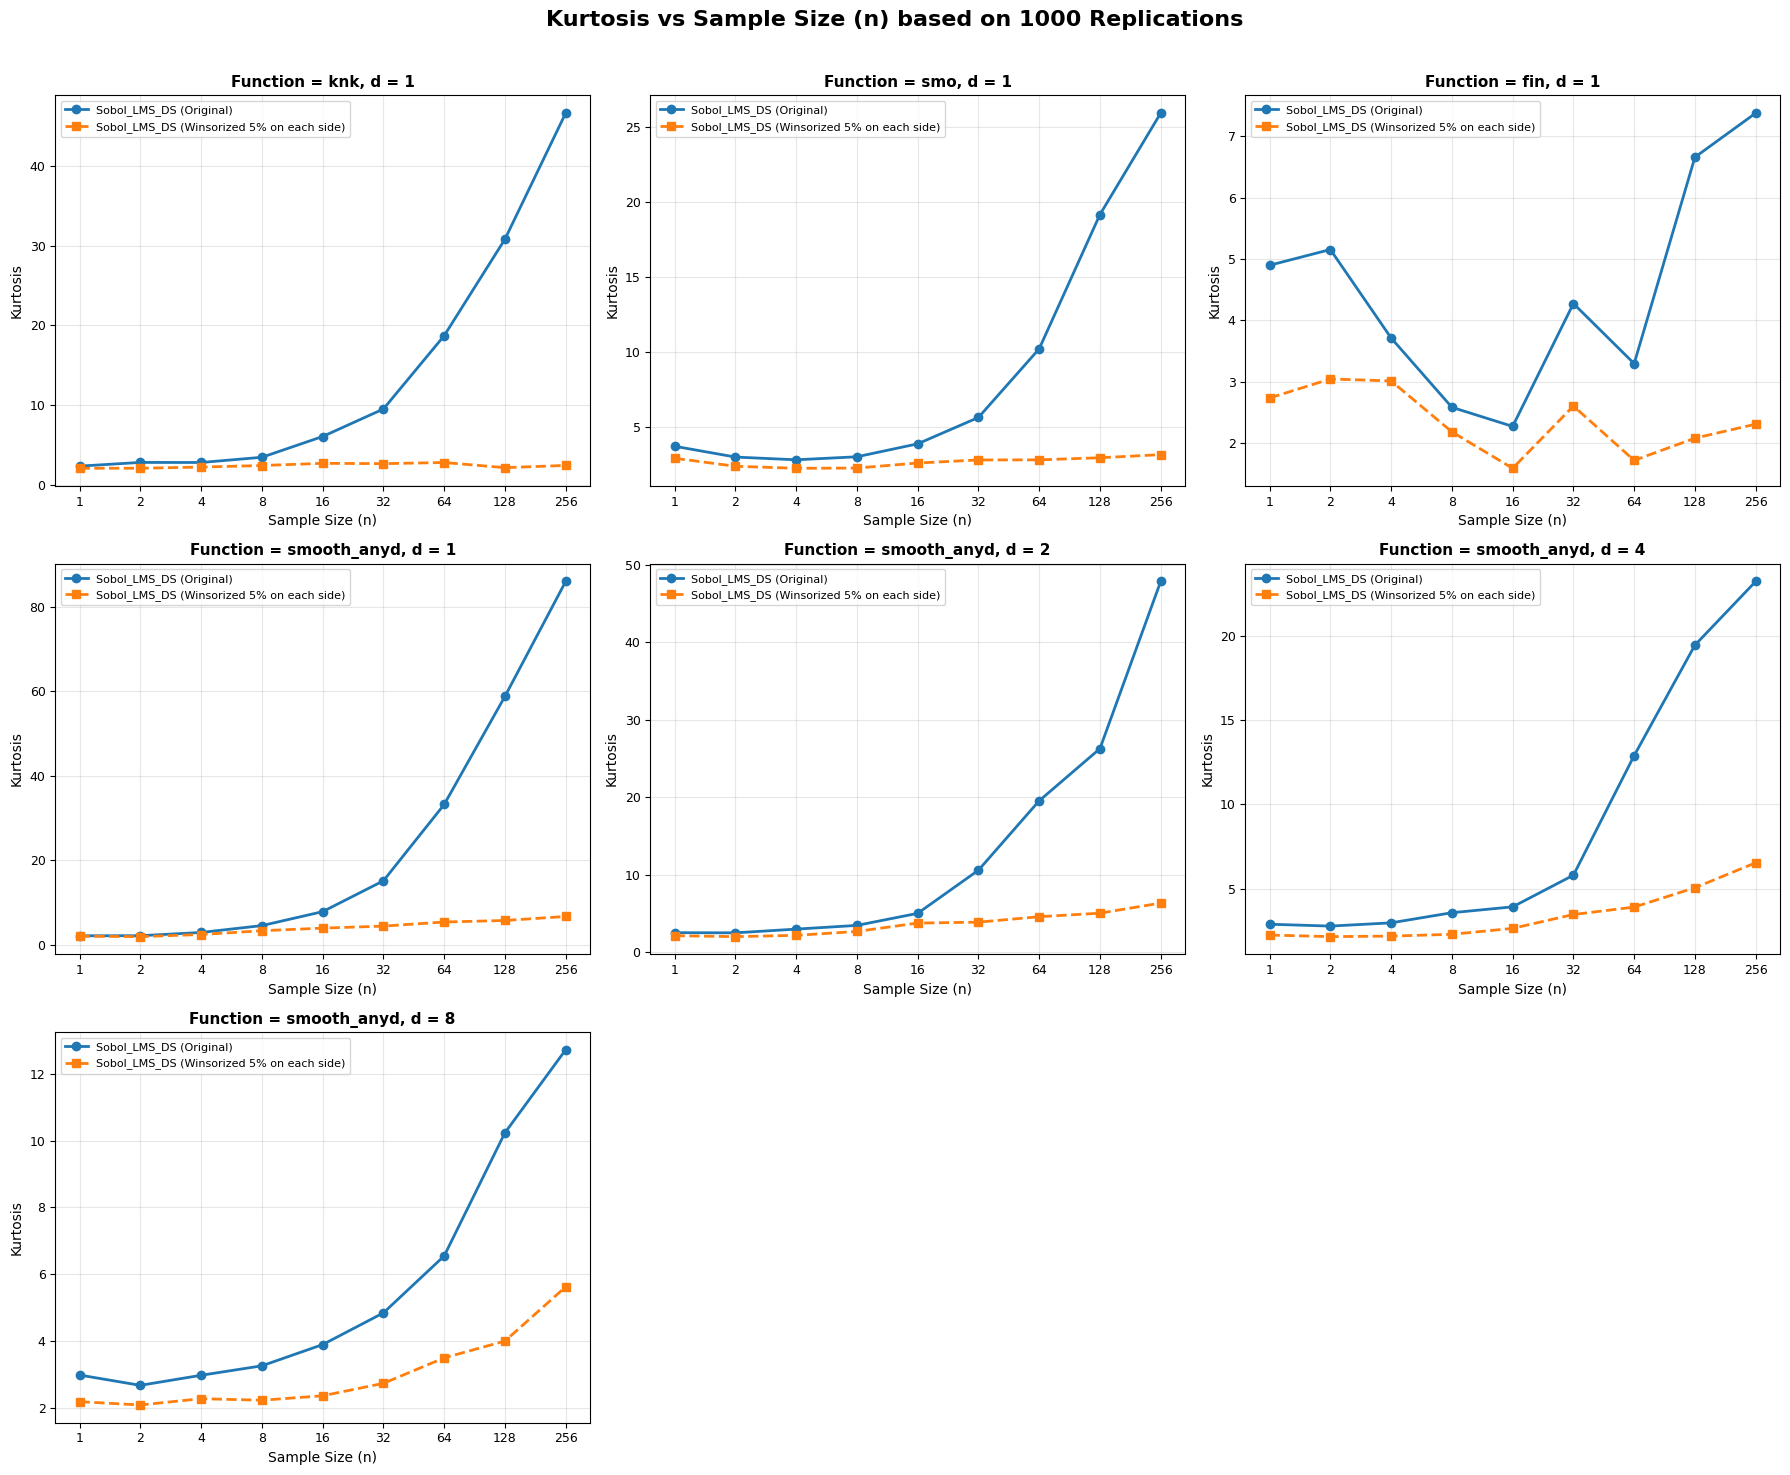

In [73]:
# Only plot for the specific function and d combinations where we have winsorized data
plot_configs = [
    (1, 0, kur_knk_d1),   # knk, d=1
    (2, 0, kur_smo_d1),   # smo, d=1
    (3, 0, kur_fin_d1),   # fin, d=1
]

# Add smooth_any_d for all d values
for i_d in range(len(d)):
    plot_configs.append((4, i_d, kur_smooth_any_d[i_d, :]))

# Create grid layout
n_plots = len(plot_configs)
n_cols = 3  # 3 columns
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Get the default color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors_cycle = prop_cycle.by_key()['color']

for idx, (i_g, i_d, kur_wins) in enumerate(plot_configs):
    ax = axes[idx]
    gname = list(gs.keys())[i_g]
    dd = d[i_d]
    
    # Plot original kurtosis for LMS_DS with first color
    ax.plot(
        n_vary,
        kurr_ridge[0, i_d, i_g, :],
        marker='o', linewidth=2, markersize=6,
        color=colors_cycle[0],
        label=f"{labels[0]} (Original)"
    )
    
    # Plot winsorized kurtosis with second color
    ax.plot(
        n_vary,
        kur_wins,
        marker='s', linewidth=2, markersize=6, linestyle='--',
        color=colors_cycle[1],
        label=f"{labels[0]} (Winsorized 5% on each side)"
    )
        
    ax.set_xscale('log', base=2)
    ax.set_xticks(n_vary)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlabel("Sample Size (n)")
    ax.set_ylabel("Kurtosis")
    ax.set_title(f"Function = {gname}, d = {dd}", fontsize=11, weight='bold')
    ax.grid(True, which="both", alpha=0.3)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc='best', fontsize=8)

# Hide any unused subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

fig.suptitle(f"Kurtosis vs Sample Size (n) based on {R} Replications", 
             fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

As we can see here, doing winsorize (5% on each side) greatly reduces the kurtois values.